<a href="https://colab.research.google.com/github/arsalanmubeen/IBA/blob/main/Autoencoder_and_GAN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

Download dataset from Kaggle from one of the following domains: Retail, Finance, Healthcare, Telecom

Note: data should NOT be image data. It should be textual data.

Train a variational autoencoder and vanilla autoencoder to generate the same data (design the problem yourself - you can get lot of help from online sources). Compare performance (try out different performance metrics, e.g., RMSE, Wasserstein distance etc.)

Use vanilla GAN for the above task and regenerate the same data. How does it compare?

Please be thorough.

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.manifold import TSNE
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.naive_bayes import GaussianNB

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 88% 58.0M/66.0M [00:00<00:00, 94.7MB/s]
100% 66.0M/66.0M [00:00<00:00, 101MB/s] 


In [ ]:
data = pd.read_csv('/content/creditcardfraud.zip') # Reading the file .csv
df = pd.DataFrame(data) # Converting data to Panda DataFrame
df2=df

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Normalization Amount
from sklearn.preprocessing import StandardScaler
df['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
df1=df

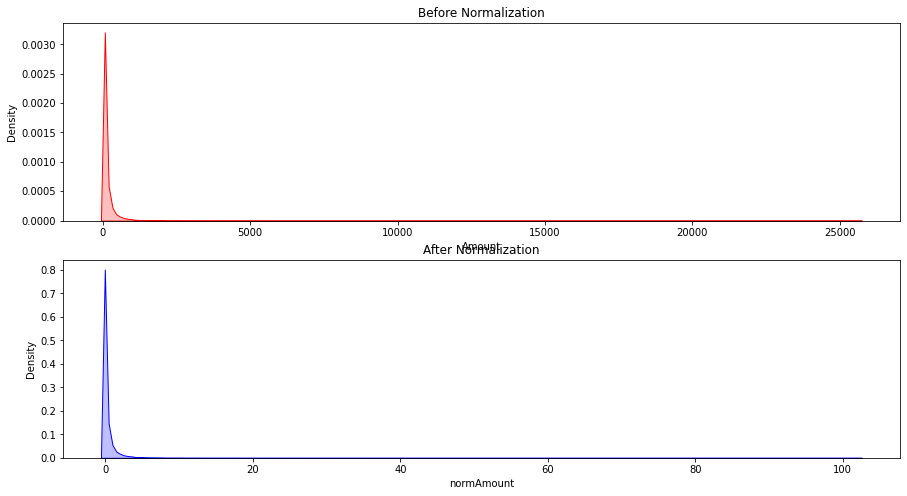

In [ ]:
#make sure there are no change in distribution 
f, (ax1, ax2) = plt.subplots(2,1,figsize =( 15, 8))

sns.kdeplot(data['Amount'],shade=True, ax = ax1, color='red')
ax1.set_title('Before Normalization')

sns.kdeplot(data['normAmount'],shade=True, ax = ax2, color='blue')
ax2.set_title('After Normalization')

plt.show()

In [ ]:
# Drop useless variables
df = df.drop(['Amount','Time'],axis=1)

In [ ]:
# The classes imbalanced.The problem here is Imbalanced Data set lead to biased to the majority class
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


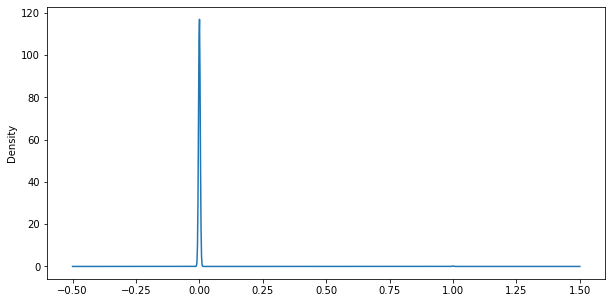

In [ ]:
df['Class'].plot(kind="density", figsize=(10,5))

In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Consider only 10000 rows of non fraud cases

In [ ]:
non_fraud = df[df['Class'] == 0].sample(1000)
fraud = df[df['Class'] == 1]

df1 = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df1.drop(['Class'], axis = 1).values
Y = df1["Class"].values

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


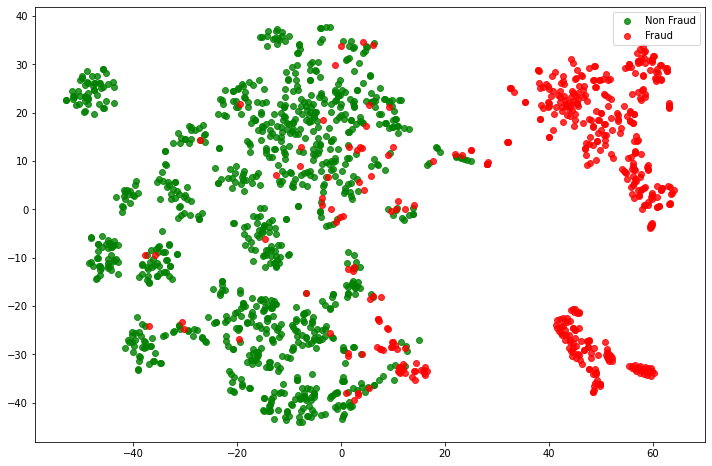

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

# 1.Variational Autoencoder (VAE)

In [ ]:
X1_train, X1_test  = train_test_split(df2, test_size=0.25)

In [ ]:
data['Amount'].skew()

16.977724453761024

In [ ]:
X1_train.loc[:,"Time"] = X1_train["Time"].apply(lambda x : x / 3600 % 24)#transform the Time field to time-of-day to account 
X1_train.loc[:,'Amount'] = np.log(X1_train['Amount']+1) #The Amount field is transformed to log scale deal with

X1_test.loc[:,"Time"] = X1_test["Time"].apply(lambda x : x / 3600 % 24)
X1_test.loc[:,'Amount'] = np.log(X1_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(X1_train.shape)
X1_train.head()

(213605, 32)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,normAmount
206433,13.835556,2.130995,0.011071,-1.776042,0.075990,0.645633,-0.503162,0.235267,-0.301603,0.533172,-0.012371,-1.268083,0.366634,0.891488,0.294721,0.766261,-0.001597,-0.838094,0.133916,0.057065,-0.140777,0.199781,0.734149,-0.067968,0.086609,0.408614,-0.100994,-0.021803,-0.057153,1.790091,0,-0.333279
225948,16.126389,2.162000,-1.150182,-0.948387,-1.240075,-0.530427,0.504667,-1.224768,0.272833,0.101015,0.903122,-0.155965,-0.829649,-1.120298,-0.028054,-0.157226,1.792100,-0.386571,-0.557089,1.244859,-0.032530,-0.068797,-0.344818,0.295246,-0.425442,-0.441341,-0.466027,-0.006317,-0.054929,3.230014,0,-0.256156
9664,4.015000,-2.907468,2.273657,-0.311679,-0.827752,-1.773097,-0.616131,-1.566515,2.126202,0.710742,-1.260116,1.047527,-1.425168,1.623088,2.961152,-0.862856,1.481941,0.505211,1.044190,-0.574748,-0.450599,0.251098,0.241963,0.049184,0.004556,-0.288442,0.829032,-0.666409,-0.104953,2.769459,0,-0.293458
258065,20.021389,-0.680607,1.710043,-1.444416,0.911736,1.205534,-0.013400,1.704699,-0.107055,-0.571517,-0.472105,-1.326507,-0.681117,-0.244437,-1.036168,-0.026250,-0.425455,1.107774,0.569176,0.821001,-0.031609,-0.045741,0.281787,-0.235591,-0.084933,0.142024,-0.406958,-0.012559,-0.068369,4.707095,0,0.085481
227735,16.332778,1.736668,-0.679831,-1.005109,0.517288,-0.327882,-0.407471,-0.057440,-0.091112,0.543660,0.195706,0.549368,0.895239,-0.038285,0.333294,-0.414238,0.387125,-0.771360,0.233416,0.236605,0.078369,0.071381,0.016523,0.053850,-0.311261,-0.251454,0.205319,-0.069417,-0.042241,4.983264,0,0.226293


In [ ]:
X1_train = X1_train[X1_train.Class == 0] # train the model on normal transactions
X1_train = X1_train.drop(['Class'], axis=1)

y1_test = X1_test['Class']
X1_test  = X1_test.drop(['Class'], axis=1) #drop the class column


#transform to ndarray
X1_train = X1_train.values
X1_test = X1_test.values
X1_train.shape

(213227, 31)

In [ ]:
#Build Model
#The first two layers are used for encoder, the last two go for the decoder.
#Use L1 regularization during training

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X1_train.shape[1] #num of columns, 29
encoding_dim = 14
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, 
                activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
nb_epoch = 300
batch_size = 128
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error',optimizer='adam')


tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X1_train, X1_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X1_test, X1_test),
                          verbose=1)

Epoch 1/300
1666/1666 [==============================] - 5s 3ms/step - loss: 4.5617 - accuracy: 0.7757 - val_loss: 1.9388 - val_accuracy: 0.9722
Epoch 2/300
1666/1666 [==============================] - 4s 2ms/step - loss: 1.3494 - accuracy: 0.9720 - val_loss: 1.1344 - val_accuracy: 0.9730
Epoch 3/300
1666/1666 [==============================] - 4s 2ms/step - loss: 0.9838 - accuracy: 0.9744 - val_loss: 0.9863 - val_accuracy: 0.9757
Epoch 4/300
1666/1666 [==============================] - 4s 2ms/step - loss: 0.8989 - accuracy: 0.9755 - val_loss: 0.9412 - val_accuracy: 0.9767
Epoch 5/300
1666/1666 [==============================] - 4s 2ms/step - loss: 0.8691 - accuracy: 0.9767 - val_loss: 0.9193 - val_accuracy: 0.9773
Epoch 6/300
1666/1666 [==============================] - 4s 2ms/step - loss: 0.8470 - accuracy: 0.9773 - val_loss: 0.8930 - val_accuracy: 0.9783
Epoch 7/300
1666/1666 [==============================] - 4s 2ms/step - loss: 0.8214 - accuracy: 0.9786 - val_loss: 0.8717 - val_ac

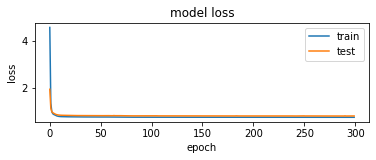

In [ ]:
# plot mse during training
plt.subplot(212)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Make prediction

In [ ]:
predictions = autoencoder.predict(X1_test)
mse = np.mean(np.power(X1_test - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse,'true_class': y1_test})
df_error.describe()

,reconstruction_error,true_class
count,71202.000000,71202.000000
mean,0.806397,0.001601
std,6.442487,0.039982
min,0.076467,0.000000
25%,0.306605,0.000000
50%,0.463703,0.000000
75%,0.697462,0.000000
max,1471.621773,1.000000


ROC Curve for Model evalution

In [ ]:
# Import modules
from sklearn.metrics import auc, roc_curve,precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import recall_score,f1_score,precision_recall_fscore_support

fpr_rf, tpr_rf, thresholds_rf  = roc_curve(df_error.true_class, df_error.reconstruction_error)
auc_rf  = auc(fpr_rf, tpr_rf)

# Plot the roc curve

#plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

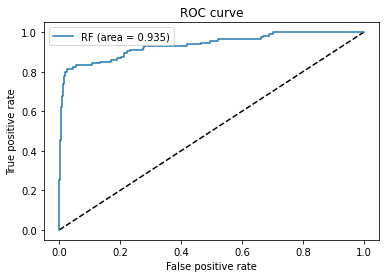

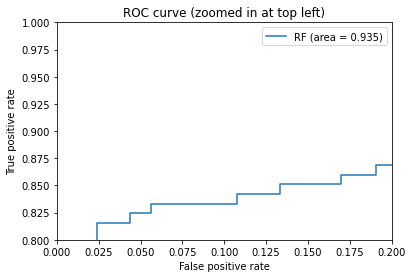

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# 2.Generational Adversarial Networks (GANs)

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [ ]:
df = pd.read_csv('/content/creditcardfraud.zip')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
df = df.drop('Time',axis=1)

In [ ]:
X = df.drop('Class',axis=1).values 
y = df['Class'].values

In [ ]:
X.mean()

3.046538594859701

In [ ]:
X.shape

(284807, 29)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras import initializers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

tensorflow.keras .backend.set_image_data_format('channels_first')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 10

In [ ]:
def build_generator(latent_dim,data_dim):

        model = Sequential()

        model.add(Dense(16, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(32, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(data_dim,activation='tanh'))

        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [ ]:
generator = build_generator(latent_dim=10,data_dim=29)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                176       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [ ]:
def build_discriminator(data_dim,num_classes):
    model = Sequential()
    model.add(Dense(31,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.25))
    model.add(Dense(16,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    
    model.summary()
    img = Input(shape=(data_dim,))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(num_classes+1, activation="softmax")(features)
    return Model(img, [valid, label])

In [ ]:
discriminator = build_discriminator(data_dim=29,num_classes=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 31)                930       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 31)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 31)               124       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 31)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                512       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16)                0         
                                                      

In [ ]:
optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
    loss_weights=[0.5, 0.5],
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
noise = Input(shape=(10,))
img = generator(noise)
discriminator.trainable = False
valid,_ = discriminator(img)
combined = Model(noise , valid)
combined.compile(loss=['binary_crossentropy'],
    optimizer=optimizer)

In [ ]:
X_train.shape

(256326, 29)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
rus = RandomUnderSampler(random_state=42)

In [ ]:
X_res, y_res = rus.fit_resample(X, y)

In [ ]:
X_res.shape

(984, 29)

In [ ]:
X_res -= X_res.min()
X_res /= X_res.max()

In [ ]:
X_test -= X_test.min()
X_test /= X_test.max()

In [ ]:
X_test_res, y_test_res = rus.fit_resample(X_test,y_test)

In [ ]:
y_res.shape

(984,)

In [ ]:

def train(X_train,y_train,
          X_test,y_test,
          generator,discriminator,
          combined,
          num_classes,
          epochs, 
          batch_size=128):
    
    f1_progress = []
    d_loss_progress = []
    half_batch = int(batch_size / 2)

    noise_until = epochs

    # Class weights:
    # To balance the difference in occurences of digit class labels.
    # 50% of labels that the discriminator trains on are 'fake'.
    # Weight = 1 / frequency
   
    cw1 = {0: 1, 1: 1}
    cw2 = {i: num_classes / half_batch for i in range(num_classes)}
    cw2[num_classes] = 1 / half_batch
    d_loss_sum = 0

    for epoch in range(epochs):
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, 10))
        gen_imgs = generator.predict(noise)

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))
        
        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((half_batch, 1), num_classes), num_classes=num_classes+1)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 10))
        validity = np.ones((batch_size, 1))

        # Train the generator
        g_loss = combined.train_on_batch(noise, validity)

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
        d_loss_sum += 100*d_loss[3]
        
        if epoch % 10 == 0:
            _,y_pred = discriminator.predict(X_test,batch_size=batch_size)
            #print(y_pred.shape)
            y_pred = np.argmax(y_pred[:,:-1],axis=1)
            
            f1 = f1_score(y_test,y_pred)
            print('Epoch: {}, F1: {:.5f}, F1P: {}'.format(epoch,f1,len(f1_progress)))
            cm = confusion_matrix(y_test, y_pred)

            print(cm)
            print(d_loss_sum/10)
            d_loss_progress.append(d_loss_sum/10)
            f1_progress.append(f1)
            d_loss_sum = 0
    
    return f1_progress, d_loss_progress

In [ ]:
f1_p, d_l_p = train(X_res,y_res,
             X_test,y_test,
             generator,discriminator,
             combined,
             num_classes=2,
             epochs=2000, 
             batch_size=128)

0 [D loss: 1.251867, acc: 39.06%, op_acc: 31.25%] [G loss: 0.430201]
Epoch: 0, F1: 0.00000, F1P: 0
[[28405    27]
 [   49     0]]
3.90625
1 [D loss: 1.274010, acc: 36.72%, op_acc: 28.91%] [G loss: 0.395930]
2 [D loss: 1.232395, acc: 33.59%, op_acc: 29.69%] [G loss: 0.412928]
3 [D loss: 1.248655, acc: 35.16%, op_acc: 34.38%] [G loss: 0.458134]
4 [D loss: 1.209759, acc: 44.53%, op_acc: 32.03%] [G loss: 0.408414]
5 [D loss: 1.198596, acc: 33.59%, op_acc: 35.16%] [G loss: 0.421078]
6 [D loss: 1.202173, acc: 38.28%, op_acc: 32.81%] [G loss: 0.492634]
7 [D loss: 1.192323, acc: 34.38%, op_acc: 37.50%] [G loss: 0.380016]
8 [D loss: 1.177773, acc: 39.84%, op_acc: 38.28%] [G loss: 0.457234]
9 [D loss: 1.169183, acc: 31.25%, op_acc: 38.28%] [G loss: 0.579261]
10 [D loss: 1.197061, acc: 32.81%, op_acc: 36.72%] [G loss: 0.555896]
Epoch: 10, F1: 0.00000, F1P: 1
[[28431     1]
 [   49     0]]
36.015625
11 [D loss: 1.153139, acc: 37.50%, op_acc: 40.62%] [G loss: 0.464145]
12 [D loss: 1.215099, acc: 45

Text(0, 0.5, 'F1 Score Validation')

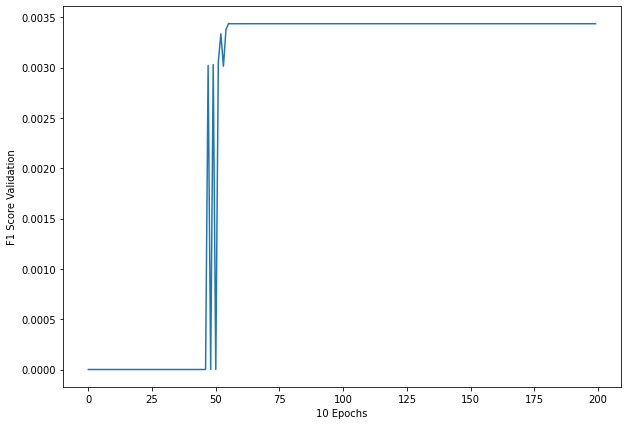

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.plot(f1_p)
plt.xlabel('10 Epochs')
plt.ylabel('F1 Score Validation')

Text(0, 0.5, 'Accuracy')

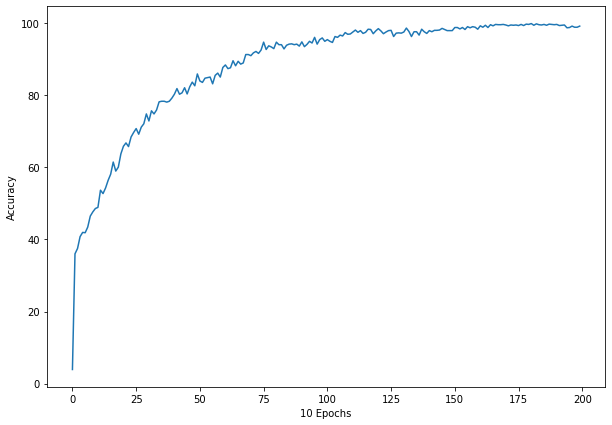

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.plot(d_l_p)
plt.xlabel('10 Epochs')
plt.ylabel('Accuracy')